In [2]:
import numpy as np
from scipy.stats import norm
from scipy.stats import invgauss
import math
import scipy.stats as stats
import pandas as pd

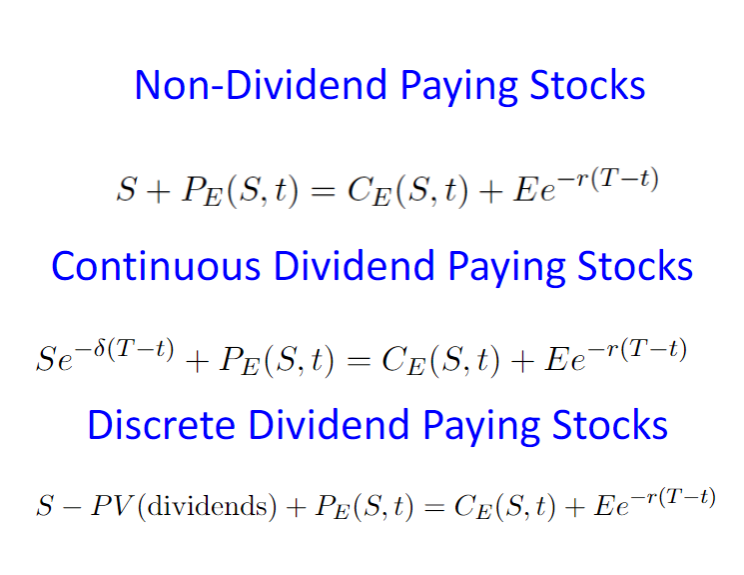

In [36]:
# Put-call parity for Non-Dividend Paying Stocks
def non_dividend_put_call_parity(S, K, r, T, option_type, option_price):
    """
    Calculate the price of the corresponding option using put-call parity for non-dividend paying stocks.
    
    Parameters:
        S (float): Current stock price.
        K (float): Strike price.
        r (float): Annual risk-free interest rate.
        T (float): Time to expiration in years.
        option_type (str): Type of the known option ('call' or 'put').
        option_price (float): Price of the known option.
    
    Returns:
        float: Price of the unknown option.
    """
    if option_type.lower() == 'call':
        return option_price - (S - K * np.exp(-r * T))  # Calculate put price
    else:
        return option_price + (S - K * np.exp(-r * T))  # Calculate call price

# Put-call parity for Discrete Dividend Paying Stocks
def discrete_dividend_put_call_parity(S, K, r, T, D, option_type, option_price):
    """
    Calculate the price of the corresponding option using put-call parity for discrete dividend paying stocks.
    
    Parameters:
        S (float): Current stock price.
        K (float): Strike price.
        r (float): Annual risk-free interest rate.
        T (float): Time to expiration in years.
        D (float): Present value of dividends paid during the life of the option.
        option_type (str): Type of the known option ('call' or 'put').
        option_price (float): Price of the known option.
    
    Returns:
        float: Price of the unknown option.
    """
    adjusted_S = S - D
    if option_type.lower() == 'call':
        return option_price - (adjusted_S - K * np.exp(-r * T))  # Calculate put price
    else:
        return option_price + (adjusted_S - K * np.exp(-r * T))  # Calculate call price

# Put-call parity for Continuous Dividend Paying Stocks
def continuous_dividend_put_call_parity(S, K, r, q, T, option_type, option_price):
    """
    Calculate the price of the corresponding option using put-call parity for continuous dividend paying stocks.
    
    Parameters:
        S (float): Current stock price.
        K (float): Strike price.
        r (float): Annual risk-free interest rate.
        q (float): Continuous dividend yield.
        T (float): Time to expiration in years.
        option_type (str): Type of the known option ('call' or 'put').
        option_price (float): Price of the known option.
    
    Returns:
        float: Price of the unknown option.
    """
    adjusted_S = S * np.exp(-q * T)
    if option_type.lower() == 'call':
        return option_price - (adjusted_S - K * np.exp(-r * T))  # Calculate put price
    else:
        return option_price + (adjusted_S - K * np.exp(-r * T))  # Calculate call price
    
def calculate_present_value(cash_flows, times, annual_rate):
    """
    Calculate the present value of multiple cash flows with a continuously compounded interest rate.
    
    Parameters:
        cash_flows (list of float): The amounts of the future cash flows.
        times (list of float): The times in years at which each cash flow will be received.
        annual_rate (float): The annual continuously compounded interest rate.
    
    Returns:
        float: The total present value of all cash flows.
    """
    pv_total = 0
    for cash_flow, time in zip(cash_flows, times):
        pv = cash_flow * np.exp(-annual_rate * time)
        pv_total += pv
    return pv_total

def calculate_arbitrage(S, C, P, K, r, T):
    right_side = S - K * np.exp(-r * T)  # Calculating the right side of the put-call parity
    left_side = C - P  # Calculating the left side of the put-call parity
    arbitrage = left_side - right_side  # Arbitrage opportunity if non-zero
    return arbitrage

def binomial_option_pricing(type, current_price, strike_price, up_factor, down_factor, interest_rate, dividend_rate,time_to_expiry, num_steps):
    stock_tree = np.zeros((num_steps + 1, num_steps + 1))
    option_tree = np.zeros((num_steps + 1, num_steps + 1))
    delta_tree = np.zeros((num_steps, num_steps))
    beta_tree = np.zeros((num_steps, num_steps))

    for i in range(num_steps + 1):
        for j in range(i + 1):
            stock_tree[i - j, i] = current_price * (up_factor ** j) * (down_factor ** (i - j))

    for j in range(num_steps + 1):
        if type == 'call':
            option_tree[j, num_steps] = max(0, stock_tree[j, num_steps] - strike_price)
        elif type == 'put':
            option_tree[j, num_steps] = max(0, strike_price - stock_tree[j, num_steps])

    delta_t = time_to_expiry / num_steps
    er_delta_t = math.exp((interest_rate-dividend_rate) * delta_t)
    p = (er_delta_t - down_factor) / (up_factor - down_factor)

    for i in range(num_steps - 1, -1, -1):
        for j in range(i + 1):
            Vu = option_tree[j, i + 1]
            Vd = option_tree[j + 1, i + 1]
            option_tree[j, i] = (p * Vu + (1 - p) * Vd) * math.exp(-interest_rate * delta_t)
            delta_tree[j, i], beta_tree[j, i] = calculate_derivative_price(Vu, Vd, stock_tree[j, i], up_factor, down_factor, interest_rate, delta_t)

    return option_tree[0, 0], stock_tree, option_tree, delta_tree, beta_tree, p


def binomial_option_pricing_american(type, current_price, strike_price, up_factor, down_factor, interest_rate, dividend_rate, time_to_expiry, num_steps):
    stock_tree = np.zeros((num_steps + 1, num_steps + 1))
    option_tree = np.zeros((num_steps + 1, num_steps + 1))
    delta_tree = np.zeros((num_steps, num_steps))
    beta_tree = np.zeros((num_steps, num_steps))
    early_exercise = False

    for i in range(num_steps + 1):
        for j in range(i + 1):
            stock_tree[i - j, i] = current_price * (up_factor ** j) * (down_factor ** (i - j))

    for j in range(num_steps + 1):
        if type == 'call':
            option_tree[j, num_steps] = max(0, stock_tree[j, num_steps] - strike_price)
        elif type == 'put':
            option_tree[j, num_steps] = max(0, strike_price - stock_tree[j, num_steps])

    delta_t = time_to_expiry / num_steps
    er_delta_t = math.exp((interest_rate - dividend_rate) * delta_t)
    p = (er_delta_t - down_factor) / (up_factor - down_factor)

    for i in range(num_steps - 1, -1, -1):
        for j in range(i + 1):
            Vu = option_tree[j, i + 1]
            Vd = option_tree[j + 1, i + 1]
            expected_value = (p * Vu + (1 - p) * Vd) * math.exp(-interest_rate * delta_t)

            # Exercise or hold the option, depending on the type and the maximum value at this node
            if type == 'call':
                if (stock_tree[j, i] - strike_price) > expected_value:
                    early_exercise = True
                option_tree[j, i] = max(stock_tree[j, i] - strike_price, expected_value)
            elif type == 'put':
                if (strike_price - stock_tree[j, i]) > expected_value:
                    early_exercise = True
                option_tree[j, i] = max(strike_price - stock_tree[j, i], expected_value)

            delta_tree[j, i], beta_tree[j, i] = calculate_derivative_price(Vu, Vd, stock_tree[j, i], up_factor, down_factor, interest_rate, delta_t)
    if early_exercise:
        print(f"Early exercise at Strike: {strike_price}")
    return option_tree[0, 0], stock_tree, option_tree, delta_tree, beta_tree

def calculate_derivative_price(high_price, low_price, stock_price, up_factor, down_factor, interest_rate, time_to_expiry):
#     neutral_prob = (np.exp((interest_rate-dividend_rate) * time_to_expiry) - down_factor) / (up_factor - down_factor)
    delta = (high_price - low_price) / (stock_price * (up_factor - down_factor))
    beta = (up_factor * low_price - down_factor * high_price) / (np.exp(interest_rate * time_to_expiry) * (up_factor - down_factor))
    return delta, beta

def up(r, delta, h, sigma):
    return np.e ** (((r-delta)*h) + (sigma * np.sqrt(h)))

def down(r, delta, h, sigma):
    return np.e ** (((r-delta)*h) - (sigma * np.sqrt(h)))

def black_scholes_call_price(current_price: float, strike_price: float, time_to_maturity: float, risk_free_rate: float, volatility: float, dividend_yield: float) -> float:
    """
    Calculate the price of a European call option using the Black-Scholes formula.

    Parameters:
    - current_price (float): Current price of the underlying asset.
    - strike_price (float): Strike price of the option.
    - time_to_maturity (float): Time to maturity of the option in years.
    - risk_free_rate (float): Annual risk-free interest rate.
    - volatility (float): Annual volatility of the underlying asset.
    - dividend_yield (float): Annual dividend yield of the underlying asset.

    Returns:
    - float: Price of the call option.
    """
    d1 = (np.log(current_price / strike_price) + (risk_free_rate - dividend_yield + 0.5 * volatility ** 2) * time_to_maturity) / (volatility * np.sqrt(time_to_maturity))
    d2 = d1 - volatility * np.sqrt(time_to_maturity)
    call_price = current_price * np.exp(-dividend_yield * time_to_maturity) * norm.cdf(d1) - strike_price * np.exp(-risk_free_rate * time_to_maturity) * norm.cdf(d2)
    return call_price

def black_scholes_put_price(current_price: float, strike_price: float, time_to_maturity: float, risk_free_rate: float, volatility: float, dividend_yield: float) -> float:
    """
    Calculate the price of a European put option using the Black-Scholes formula.

    Parameters:
    - current_price (float): Current price of the underlying asset.
    - strike_price (float): Strike price of the option.
    - time_to_maturity (float): Time to maturity of the option in years.
    - risk_free_rate (float): Annual risk-free interest rate.
    - volatility (float): Annual volatility of the underlying asset.
    - dividend_yield (float): Annual dividend yield of the underlying asset.

    Returns:
    - float: Price of the put option.
    """
    d1 = (np.log(current_price / strike_price) + (risk_free_rate - dividend_yield + 0.5 * volatility ** 2) * time_to_maturity) / (volatility * np.sqrt(time_to_maturity))
    d2 = d1 - volatility * np.sqrt(time_to_maturity)
    put_price = -current_price * np.exp(-dividend_yield * time_to_maturity) * norm.cdf(-d1) + strike_price * np.exp(-risk_free_rate * time_to_maturity) * norm.cdf(-d2)
    return put_price


def compound_interest(principal, annual_rate, times_compounded, years):
    """
    Calculate the compound interest.

    Parameters:
    principal (float): Initial amount of money
    annual_rate (float): Annual interest rate (as a decimal)
    times_compounded (int): Number of times the interest is compounded per year
    years (int): Number of years the money is invested or borrowed for

    Returns:
    float: Future value of the investment
    """
    # Calculate the future value
    future_value = principal * (1 + annual_rate / times_compounded) ** (times_compounded * years)
    return future_value

def delta_gamma_theta_approximation(delta, gamma, theta, change_in_stock_price, change_in_time):
    """
    Calculate the change in the price of a put option using the Delta-Gamma-Theta approximation.

    Parameters:
    - delta (float): Delta of the put option.
    - gamma (float): Gamma of the put option.
    - theta (float): Theta of the put option per day.
    - change_in_stock_price (float): Change in the underlying stock price.
    - change_in_time (float): Change in time in days.

    Returns:
    - float: Approximated change in the price of the put option.
    """
    delta_term = delta * change_in_stock_price
    gamma_term = 0.5 * gamma * (change_in_stock_price ** 2)
    theta_term = theta * change_in_time

    change_in_option_price = delta_term + gamma_term + theta_term
    return change_in_option_price


def compute_daily_volatility(num_days):
    # Number of days the stock doubles
    num_double = num_days // 2
    
    # Number of days the stock halves
    num_halves = num_days - num_double
    
    # Generate daily returns
    returns = np.concatenate([np.ones(num_double) * 2, np.ones(num_halves) * 0.5])
    
    # Compute standard deviation of returns
    volatility = np.std(np.log(returns))
    
    return volatility

def estimate_daily_mean_volatility(prices):
    """
    Compute the daily mean return and daily volatility from historical stock prices.
    
    Parameters:
    prices (list or np.array): A list or array of historical stock prices.
    
    Returns:
    tuple: (daily mean return, daily volatility)
    """
    # Convert prices to a numpy array if it's not already
    prices = np.array(prices)
    
    # Calculate log returns
    log_returns = np.log(prices[1:] / prices[:-1])
    
    # Calculate daily mean return
    mu_d = np.mean(log_returns)
    
    # Calculate daily volatility
    sigma_d = np.std(log_returns, ddof=1)
    
    return mu_d, sigma_d

In [34]:
def black_scholes_call(S, K, T, r, sigma):
    # T: Time to maturity in years
    # S: Current stock price
    # K: Strike price of the option
    # r: Risk-free rate
    # sigma: Volatility of the stock
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = (S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2))
    delta = norm.cdf(d1)
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
    theta = (-S * norm.pdf(d1) * sigma / (2 * np.sqrt(T))) - (r * K * np.exp(-r * T) * norm.cdf(d2)) 
    return call_price, delta, gamma, theta

def black_scholes_put(S, K, T, r, sigma):
    # T: Time to maturity in years
    # S: Current stock price
    # K: Strike price of the option
    # r: Risk-free rate
    # sigma: Volatility of the stock
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    put_price = (K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1))
    delta = norm.cdf(d1) - 1
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
    theta = (-S * norm.pdf(d1) * sigma / (2 * np.sqrt(T))) + (r * K * np.exp(-r * T) * norm.cdf(-d2))
    return put_price, delta, gamma, theta

def MarketMakerProfit(sigma, S, gamma, theta, r, delta, option_price, h):
    return -((0.5*(sigma ** 2) * (S ** 2) * gamma) + theta + (r * ((delta * S)-option_price)))*h

def calculate_means(stock_prices):
    """
    Calculate the arithmetic and geometric means of a list of stock prices.

    Parameters:
    - stock_prices: list or numpy array of stock prices

    Returns:
    - arithmetic_mean: The arithmetic mean of the stock prices
    - geometric_mean: The geometric mean of the stock prices
    """
    # Arithmetic mean calculation using numpy
    arithmetic_mean = np.mean(stock_prices)

    # Geometric mean calculation: product of all prices to the power of 1/N
    geometric_mean = np.prod(stock_prices)**(1/len(stock_prices))

    return arithmetic_mean, geometric_mean

In [55]:
# Given values
S0 = 184  # Current stock price
K = 184   # Strike price (at-the-money)
r = 0.02  # Risk-free rate
sigma = 0.30  # Volatility
T = 1     # Time to expiration in years
P = 100   # Fixed payoff

# Calculate d2
d2 = (np.log(S0 / K) + (r - 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))

# Calculate N(d2)
N_d2 = norm.cdf(d2)

# Price of the digital call option
C_digital = np.exp(-r * T) * N_d2 * P
C_digital

45.75501225426106

In [211]:
def black_scholes_call(S, K, T, r, sigma, q):
    """
    Calculate the price of a European call option using the Black-Scholes formula considering continuous dividends.
    
    Parameters:
    S (float): Current stock price
    K (float): Strike price of the option
    T (float): Time to maturity in years
    r (float): Risk-free rate
    sigma (float): Volatility of the stock
    q (float): Continuous dividend yield
    
    Returns:
    tuple: Call option price, Delta, Gamma, Theta
    """
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = (S * np.exp(-q * T) * norm.cdf(d1)) - (K * np.exp(-r * T) * norm.cdf(d2))
    delta = np.exp(-q * T) * norm.cdf(d1)
    gamma = (np.exp(-q * T) * norm.pdf(d1)) / (S * sigma * np.sqrt(T))
    theta = (-S * np.exp(-q * T) * norm.pdf(d1) * sigma / (2 * np.sqrt(T))) - (r * K * np.exp(-r * T) * norm.cdf(d2)) + (q * S * np.exp(-q * T) * norm.cdf(d1))
    
    return call_price, delta, gamma, theta

def black_scholes_put(S, K, T, r, sigma, q):
    """
    Calculate the price of a European put option using the Black-Scholes formula considering continuous dividends.
    
    Parameters:
    S (float): Current stock price
    K (float): Strike price of the option
    T (float): Time to maturity in years
    r (float): Risk-free rate
    sigma (float): Volatility of the stock
    q (float): Continuous dividend yield
    
    Returns:
    tuple: Put option price, Delta, Gamma, Theta
    """
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    put_price = (K * np.exp(-r * T) * norm.cdf(-d2)) - (S * np.exp(-q * T) * norm.cdf(-d1))
    delta = np.exp(-q * T) * (norm.cdf(d1) - 1)
    gamma = (np.exp(-q * T) * norm.pdf(d1)) / (S * sigma * np.sqrt(T))
    theta = (-S * np.exp(-q * T) * norm.pdf(d1) * sigma / (2 * np.sqrt(T))) + (r * K * np.exp(-r * T) * norm.cdf(-d2)) + (q * S * np.exp(-q * T) * norm.cdf(-d1))
    
    return put_price, delta, gamma, theta

S = 62
K = 60
sigma = 0.28
r = 0.07
q = 0.01
T1 = 73/365
T2 = 73/365
S2 = 63

(black_scholes_call(S2, K, T2, r, sigma, q)[0]-black_scholes_call(S, K, T1, r, sigma, q)[0])

def dgtHedge(A, B):
    A = np.array([[C2, P, S0, 1],
                  [deltaC2, deltaP, deltaStock, deltaB],
                  [gammaC2, gammaP, gammaStock, gammaB],
                  [VegaC2, VegaP, VegaStock, Vb]])
    B = [-C1, -deltaC1, -gammaC1, -VegaC1]
    return np.linalg.solve(A, B)

In [10]:
def black_scholes_call(S, K, T, r, sigma):
    # T: Time to maturity in years
    # S: Current stock price
    # K: Strike price of the option
    # r: Risk-free rate
    # sigma: Volatility of the stock
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = (S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2))
    delta = norm.cdf(d1)
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
    theta = (-S * norm.pdf(d1) * sigma / (2 * np.sqrt(T))) - (r * K * np.exp(-r * T) * norm.cdf(d2)) 
    return call_price, delta, gamma, theta

def black_scholes_put(S, K, T, r, sigma):
    # T: Time to maturity in years
    # S: Current stock price
    # K: Strike price of the option
    # r: Risk-free rate
    # sigma: Volatility of the stock
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    put_price = (K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1))
    delta = norm.cdf(d1) - 1
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
    theta = (-S * norm.pdf(d1) * sigma / (2 * np.sqrt(T))) + (r * K * np.exp(-r * T) * norm.cdf(-d2))
    return put_price, delta, gamma, theta
    
    
round(black_scholes_call(100, 100, 1, 0.02, 0.50)[3], 2)

-10.38

In [25]:
C180 = black_scholes_call(180, 180, 1, 0.08, 0.3)
P180 = black_scholes_put(180, 180, 1, 0.08, 0.3)
P160 = black_scholes_put(180, 160, 1, 0.08, 0.3)
C200 = black_scholes_call(180, 200, 1, 0.08, 0.3)

Pi = (C180[0] + P180[0] - P160[0] - C200[0])*-100
Pi_delta = (C180[1] + P180[1] - P160[1] - C200[1])*-100
Pi_Gamma = (C180[2] + P180[2] - P160[2] - C200[2])*-100
Pi, Pi_delta, Pi_Gamma

(-1578.0997958223643, -0.6157646086264235, -0.08503553637880368)

In [39]:
def up(r, delta, h, sigma):
    return np.e ** (((r-delta)*h) + (sigma * np.sqrt(h)))

def down(r, delta, h, sigma):
    return np.e ** (((r-delta)*h) - (sigma * np.sqrt(h)))

def binomial_option_pricing(type, current_price, strike_price, up_factor, down_factor, interest_rate, dividend_rate,time_to_expiry, num_steps):
    stock_tree = np.zeros((num_steps + 1, num_steps + 1))
    option_tree = np.zeros((num_steps + 1, num_steps + 1))
    delta_tree = np.zeros((num_steps, num_steps))
    beta_tree = np.zeros((num_steps, num_steps))

    for i in range(num_steps + 1):
        for j in range(i + 1):
            stock_tree[i - j, i] = current_price * (up_factor ** j) * (down_factor ** (i - j))

    for j in range(num_steps + 1):
        if type == 'call':
            option_tree[j, num_steps] = max(0, stock_tree[j, num_steps] - strike_price)
        elif type == 'put':
            option_tree[j, num_steps] = max(0, strike_price - stock_tree[j, num_steps])

    delta_t = time_to_expiry / num_steps
    er_delta_t = math.exp((interest_rate-dividend_rate) * delta_t)
    p = (er_delta_t - down_factor) / (up_factor - down_factor)

    for i in range(num_steps - 1, -1, -1):
        for j in range(i + 1):
            Vu = option_tree[j, i + 1]
            Vd = option_tree[j + 1, i + 1]
            option_tree[j, i] = (p * Vu + (1 - p) * Vd) * math.exp(-interest_rate * delta_t)
            delta_tree[j, i], beta_tree[j, i] = calculate_derivative_price(Vu, Vd, stock_tree[j, i], up_factor, down_factor, interest_rate, delta_t)

    return option_tree[0, 0], stock_tree, option_tree, delta_tree, beta_tree, p

S = 100
r = 0.08
sigma = 0.30
delta = 0.05
K = 100
T = 100
h = 1
binomial_option_pricing("put", 100, 100, up(r, delta, h, sigma), down(r, delta, h, sigma), r, delta,1, 1)

round(12.547447750310434-10, 2)

2.55

In [44]:
def binomial_option_pricing_american(type, current_price, strike_price, up_factor, down_factor, interest_rate, dividend_rate, time_to_expiry, num_steps):
    stock_tree = np.zeros((num_steps + 1, num_steps + 1))
    option_tree = np.zeros((num_steps + 1, num_steps + 1))
    delta_tree = np.zeros((num_steps, num_steps))
    beta_tree = np.zeros((num_steps, num_steps))
    early_exercise = False

    for i in range(num_steps + 1):
        for j in range(i + 1):
            stock_tree[i - j, i] = current_price * (up_factor ** j) * (down_factor ** (i - j))

    for j in range(num_steps + 1):
        if type == 'call':
            option_tree[j, num_steps] = max(0, stock_tree[j, num_steps] - strike_price)
        elif type == 'put':
            option_tree[j, num_steps] = max(0, strike_price - stock_tree[j, num_steps])

    delta_t = time_to_expiry / num_steps
    er_delta_t = math.exp((interest_rate - dividend_rate) * delta_t)
    p = (er_delta_t - down_factor) / (up_factor - down_factor)

    for i in range(num_steps - 1, -1, -1):
        for j in range(i + 1):
            Vu = option_tree[j, i + 1]
            Vd = option_tree[j + 1, i + 1]
            expected_value = (p * Vu + (1 - p) * Vd) * math.exp(-interest_rate * delta_t)

            # Exercise or hold the option, depending on the type and the maximum value at this node
            if type == 'call':
                if (stock_tree[j, i] - strike_price) > expected_value:
                    early_exercise = True
                option_tree[j, i] = max(stock_tree[j, i] - strike_price, expected_value)
            elif type == 'put':
                if (strike_price - stock_tree[j, i]) > expected_value:
                    early_exercise = True
                option_tree[j, i] = max(strike_price - stock_tree[j, i], expected_value)

            delta_tree[j, i], beta_tree[j, i] = calculate_derivative_price(Vu, Vd, stock_tree[j, i], up_factor, down_factor, interest_rate, delta_t)
    if early_exercise:
        print(f"Early exercise at Strike: {strike_price}")
    return option_tree[0, 0], stock_tree, option_tree, delta_tree, beta_tree

S = 41.75
T = 2/12
h = 1/12
sigma = 0.34
r = 0.0535
K = 45
up = math.pow(np.e, sigma * math.sqrt(h))
down = math.pow(np.e, -(sigma * math.sqrt(h)))

binomial_option_pricing_american("put", S, K, up, down, r, 0, T, 2)

Early exercise at Strike: 45


(4.3786596563218145,
 array([[41.75      , 46.05558318, 50.80519143],
        [ 0.        , 37.84693146, 41.75      ],
        [ 0.        ,  0.        , 34.30874781]]),
 array([[ 4.37865966,  1.62356803,  0.        ],
        [ 0.        ,  7.15306854,  3.25      ],
        [ 0.        ,  0.        , 10.69125219]]),
 array([[-0.6736186 , -0.35891014],
        [ 0.        , -1.        ]]),
 array([[32.50223636, 18.15338372],
        [ 0.        , 44.79982156]]))

In [51]:
def black_scholes_call(S, K, T, r, sigma):
    # T: Time to maturity in years
    # S: Current stock price
    # K: Strike price of the option
    # r: Risk-free rate
    # sigma: Volatility of the stock
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = (S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2))
    delta = norm.cdf(d1)
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
    theta = (-S * norm.pdf(d1) * sigma / (2 * np.sqrt(T))) - (r * K * np.exp(-r * T) * norm.cdf(d2)) 
    return call_price, delta, gamma, theta

def black_scholes_put(S, K, T, r, sigma):
    # T: Time to maturity in years
    # S: Current stock price
    # K: Strike price of the option
    # r: Risk-free rate
    # sigma: Volatility of the stock
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    put_price = (K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1))
    delta = norm.cdf(d1) - 1
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
    theta = (-S * norm.pdf(d1) * sigma / (2 * np.sqrt(T))) + (r * K * np.exp(-r * T) * norm.cdf(-d2))
    return put_price, delta, gamma, theta